In [69]:
# This tutorial is losely based on https://xiaoxiaowang87.github.io/monotonicity_constraint/

import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators import H2OGradientBoostingEstimator

import numpy as np
import pandas as pd

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import fetch_california_housing

In [48]:
cal_housing = fetch_california_housing()

In [49]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,45 mins 51 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.99999
H2O cluster version age:,1 hour and 57 minutes
H2O cluster name:,mkurka
H2O cluster total nodes:,1
H2O cluster free memory:,11.25 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [50]:
data = h2o.H2OFrame(cal_housing.data, column_names=cal_housing.feature_names)
data["target"] = h2o.H2OFrame(cal_housing.target)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [51]:
train, test = data.split_frame([0.6], seed=123)

In [52]:
train.summary()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
type,real,int,real,real,int,real,real,real,real
mins,0.4999,1.0,0.846153846154,0.375,3.0,0.692307692308,32.54,-124.35,0.14999
mean,3.88080577434,28.592896835,5.45159062686,1.09888842652,1426.40412338,3.1598055712,35.6381468954,-119.572060079,2.06838035113
maxs,15.0001,52.0,132.533333333,34.0666666667,35682.0,1243.33333333,41.95,-114.31,5.00001
sigma,1.90138273147,12.5943702314,2.51012114666,0.503062422674,1160.40981696,13.3502637259,2.14149825875,2.00443036004,1.15487252367
zeros,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0
0,8.3252,41.0,6.98412698413,1.02380952381,322.0,2.55555555556,37.88,-122.23,4.526
1,8.3014,21.0,6.2381370826,0.971880492091,2401.0,2.10984182777,37.86,-122.22,3.585
2,7.2574,52.0,8.28813559322,1.07344632768,496.0,2.80225988701,37.85,-122.24,3.521


In [53]:
test.summary()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
type,real,int,real,real,int,real,real,real,real
mins,0.4999,1.0,1.0,0.333333333333,6.0,1.16932907348,32.56,-124.3,0.14999
mean,3.85536716527,28.7098382585,5.39488676457,1.09333302879,1424.07637115,2.93603511044,35.6223701812,-119.566147391,2.06882668004
maxs,15.0001,52.0,141.909090909,25.6363636364,15507.0,83.1714285714,41.95,-114.56,5.00001
sigma,1.8974750829,12.5726769447,2.41862993425,0.426136469691,1088.96995567,1.26628333493,2.12764543091,2.00229059869,1.15264118508
zeros,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0
0,5.6431,52.0,5.81735159817,1.07305936073,558.0,2.54794520548,37.85,-122.25,3.413
1,3.6591,52.0,4.93190661479,0.951361867704,1094.0,2.12840466926,37.84,-122.25,2.992
2,2.0804,42.0,4.29411764706,1.11764705882,1206.0,2.0268907563,37.84,-122.26,2.267


In [54]:
feature_names = ['MedInc', 'AveOccup', 'HouseAge']
monotone_constraints = {"MedInc": 1, "AveOccup": -1, "HouseAge": 1}

In [55]:
xgb_mono = H2OXGBoostEstimator(monotone_constraints=monotone_constraints)
xgb_mono.train(x=feature_names, y="target", training_frame=train, validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [56]:
xgb_mono.model_performance()


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.450582394315
RMSE: 0.671254343983
MAE: 0.493647644764
RMSLE: 0.217638157557
Mean Residual Deviance: 0.450582394315


In [57]:
xgb_mono.model_performance(valid=True)


ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.491813275045
RMSE: 0.701294000434
MAE: 0.518155694956
RMSLE: 0.22897543713
Mean Residual Deviance: 0.491813275045


In [58]:
gbm_mono = H2OGradientBoostingEstimator(monotone_constraints=monotone_constraints)
gbm_mono.train(x=feature_names, y="target", training_frame=train, validation_frame=test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [59]:
gbm_mono.model_performance()


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.449986623705
RMSE: 0.670810423074
MAE: 0.494184218288
RMSLE: 0.21741684144
Mean Residual Deviance: 0.449986623705


In [60]:
gbm_mono.model_performance(valid=True)


ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.481829630737
RMSE: 0.694139489395
MAE: 0.515524158621
RMSLE: 0.226177098203
Mean Residual Deviance: 0.481829630737


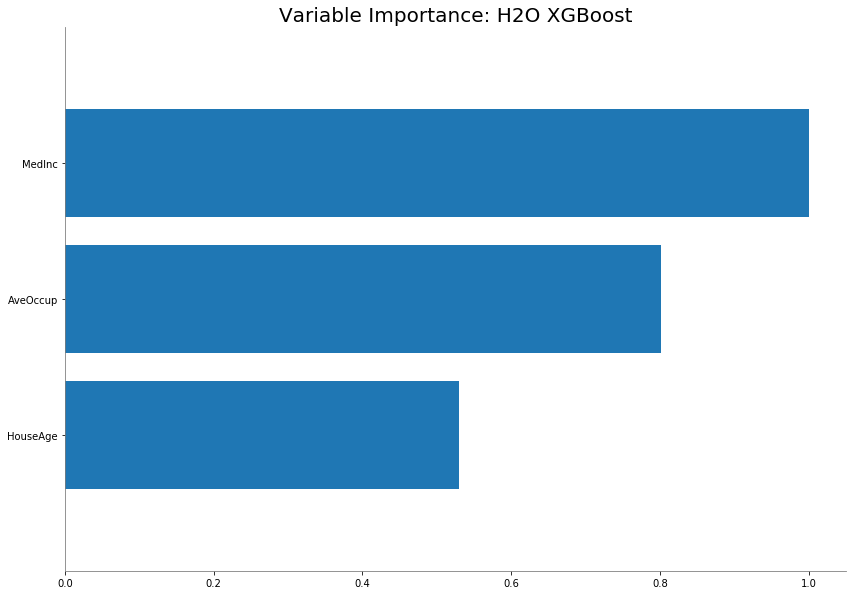

In [61]:
xgb_mono.varimp_plot()

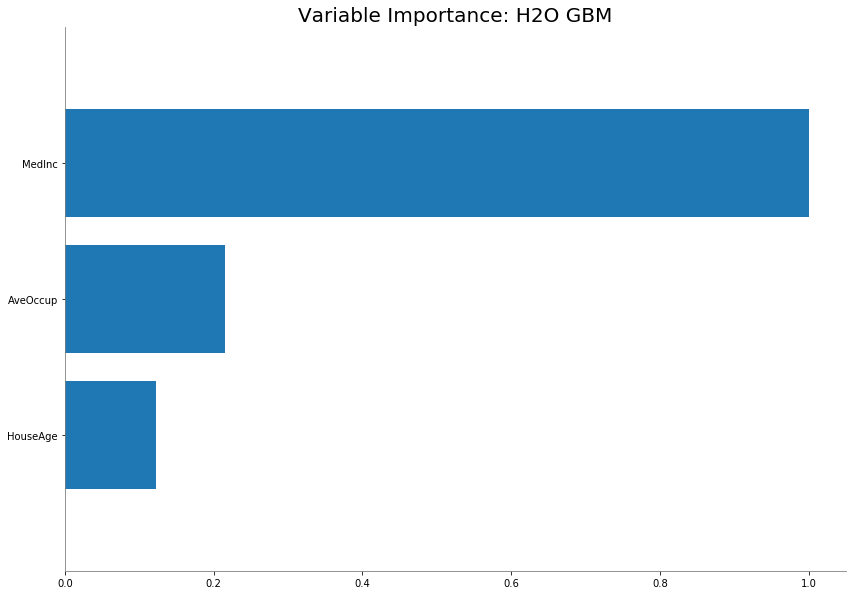

In [62]:
gbm_mono.varimp_plot()

In [63]:
data={'H2O XGBoost': [xgb_mono.rmse(), xgb_mono.rmse(valid=True)],
      'H2O GBM': [gbm_mono.rmse(), gbm_mono.rmse(valid=True)]}
pd.DataFrame.from_dict(data, columns=['Train RMSE', 'Test RMSE'], orient="index")

,Train RMSE,Test RMSE
H2O XGBoost,0.671254,0.701294
H2O GBM,0.670810,0.694139


PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model XGBoost_model_python_1543517619333_7 on column 'MedInc'



medinc,mean_response,stddev_response,std_error_mean_response
0.4999,0.9042832,0.4050025,0.0036345
0.6463667,1.0116680,0.3172816,0.0028473
0.7928333,1.0117064,0.3174680,0.0028490
0.9393,1.0137833,0.3192623,0.0028651
1.0857667,1.0144802,0.3185222,0.0028585
---,---,---,---
14.4142333,4.8378433,0.4268355,0.0038305
14.5607,4.8378433,0.4268355,0.0038305
14.7071667,4.8378433,0.4268355,0.0038305
14.8536333,4.8379129,0.4268688,0.0038308



See the whole table with table.as_data_frame()
PartialDependence: Partial Dependence Plot of model XGBoost_model_python_1543517619333_7 on column 'AveOccup'



aveoccup,mean_response,stddev_response,std_error_mean_response
0.6923077,4.7145734,1.6517448,0.0148229
13.2442372,1.5843531,0.8072629,0.0072445
25.7961668,1.5843531,0.8072629,0.0072445
38.3480963,1.5843531,0.8072629,0.0072445
50.9000259,1.5843531,0.8072629,0.0072445
---,---,---,---
1193.1256151,-1.1011310,0.7744430,0.0069499
1205.6775447,-1.1011310,0.7744430,0.0069499
1218.2294742,-1.1011310,0.7744430,0.0069499
1230.7814038,-1.1011310,0.7744430,0.0069499



See the whole table with table.as_data_frame()
PartialDependence: Partial Dependence Plot of model XGBoost_model_python_1543517619333_7 on column 'HouseAge'



houseage,mean_response,stddev_response,std_error_mean_response
1.0,1.4583174,0.8679680,0.0077892
2.0,1.4583174,0.8679680,0.0077892
3.0,1.6582169,0.8473530,0.0076042
4.0,1.7134339,0.8369214,0.0075106
5.0,1.7160654,0.8339999,0.0074844
---,---,---,---
48.0,2.3312915,0.9915394,0.0088982
49.0,2.3327401,0.9897468,0.0088821
50.0,2.3413390,0.9806541,0.0088005
51.0,2.4553383,0.9887533,0.0088732



See the whole table with table.as_data_frame()


[, , ]

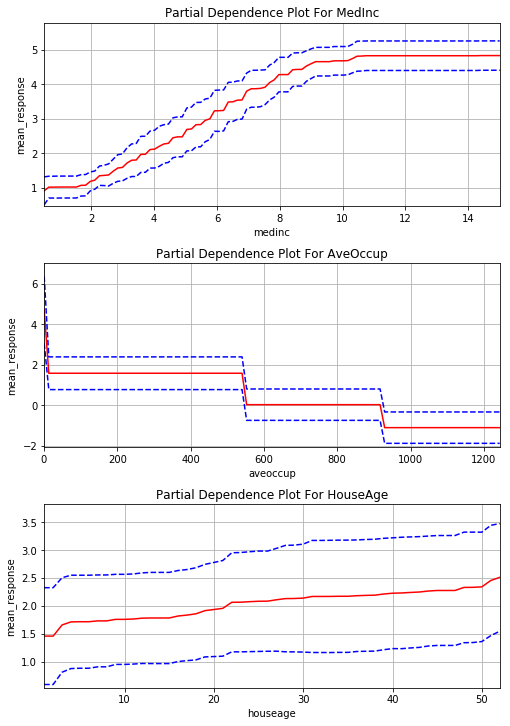

In [64]:
xgb_mono.partial_plot(data=train, cols=feature_names, nbins=100)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1543517619333_8 on column 'MedInc'



medinc,mean_response,stddev_response,std_error_mean_response
0.4999,1.0842446,0.2019811,0.0018126
0.6463667,1.0842446,0.2019811,0.0018126
0.7928333,1.0842446,0.2019811,0.0018126
0.9393,1.0842446,0.2019811,0.0018126
1.0857667,1.0842446,0.2019811,0.0018126
---,---,---,---
14.4142333,4.7717826,0.2258950,0.0020272
14.5607,4.7717826,0.2258950,0.0020272
14.7071667,4.7717826,0.2258950,0.0020272
14.8536333,4.7717826,0.2258950,0.0020272



See the whole table with table.as_data_frame()
PartialDependence: Partial Dependence Plot of model GBM_model_python_1543517619333_8 on column 'AveOccup'



aveoccup,mean_response,stddev_response,std_error_mean_response
0.6923077,3.1477957,0.9659091,0.0086682
13.2442372,1.6114909,0.7182429,0.0064456
25.7961668,1.6114909,0.7182429,0.0064456
38.3480963,1.6114909,0.7182429,0.0064456
50.9000259,1.6114909,0.7182429,0.0064456
---,---,---,---
1193.1256151,1.6114909,0.7182429,0.0064456
1205.6775447,1.6114909,0.7182429,0.0064456
1218.2294742,1.6114909,0.7182429,0.0064456
1230.7814038,1.6114909,0.7182429,0.0064456



See the whole table with table.as_data_frame()
PartialDependence: Partial Dependence Plot of model GBM_model_python_1543517619333_8 on column 'HouseAge'



houseage,mean_response,stddev_response,std_error_mean_response
1.0,1.7299145,0.7237023,0.0064946
2.0,1.7299145,0.7237023,0.0064946
3.0,1.7659286,0.7296043,0.0065476
4.0,1.7807129,0.7446737,0.0066828
5.0,1.7826570,0.7470610,0.0067042
---,---,---,---
48.0,2.3636941,0.9871769,0.0088590
49.0,2.3636941,0.9871769,0.0088590
50.0,2.3636941,0.9871769,0.0088590
51.0,2.4644215,0.9782047,0.0087785



See the whole table with table.as_data_frame()


[, , ]

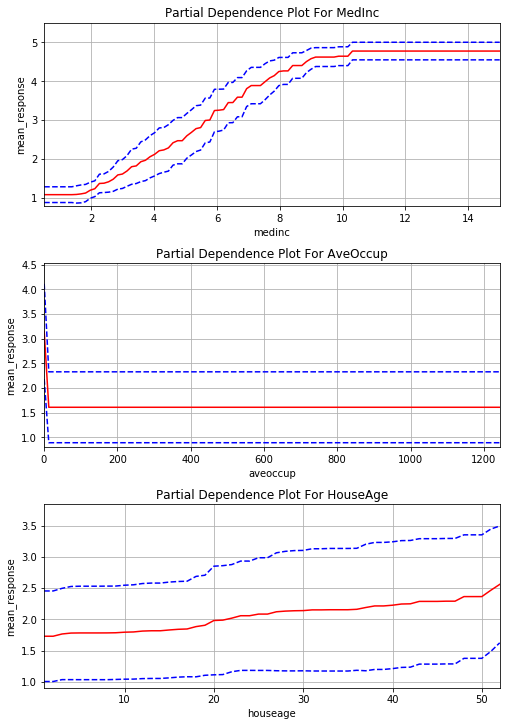

In [65]:
gbm_mono.partial_plot(data=train, cols=feature_names, nbins=100)